## Часть 1. Парсинг (10 баллов)

Мы предлагаем вам распарсить часть данных litres.ru — а именно часть про книги, имеющие отношение к программированию.

Они находятся в этом каталоге: https://www.litres.ru/genre/programmirovanie-5272/

Вам нужно собрать датасет о книгах с первых 40-ти страниц каталога (около 960 книг.)
*Подсказка.* Можете начать с исследования html кода этой страницы.

Вам необходимо собрать датасет, содержащий следующие данные:
* name: название книги
* author: автор
* link: ссылка на книгу
* rating: рейтинг по 5-балльной шкале
* rating_count: количество оценок
* review_count: количество отзывов
* pages_count: объем (число страниц)
* price: цена
* text_reviews: тексты отзывов: список строк
* age: возрастное ограничение
* year: год написания

В дальнейшем вам нужно будет анализировать полученный у вас датасет.

Если у вас не получилось спарсить датасет, воспользуйтесь для последующих пунктов готовым датасетом: https://disk.yandex.ru/d/2UZet2-qxRxF6Q

 Так вы сможете получить баллы за вторую часть.

(Датасет неидеален, с ним придется поработать!)

**Парсите "вежливо": используйте time.sleep() не меньше 1-2 секунд между запросами к сайту!**

# Дисклеймер #

Давайте представим, что код парсинга хорошо обернут в Try Exceptы, логирование, проверки на коды ответов и все остальное, cause I can't be asked to do all of this.

У каждой книги есть только один автор - если их два, считается и парсится только первый. Цена - final_price.

Также из отзывов по каждой книге парсятся только первые 5, потому что для подгрузки остальных нужно ткнуть на кнопку "больше отзывов". Она не меняет url страницы, поэтому через requests.get это кажется не отловить. Но можно было бы Seleniumom, но опять же can't be asked for 10 points, lads.


Otherwise enjoy!

In [1]:
%pip install requests

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [87]:
import requests
from bs4 import BeautifulSoup
import time
import json
import re

def get_page_url(i):
    if i == 1:
        return "https://www.litres.ru/genre/programmirovanie-5272/"
    return f"https://www.litres.ru/genre/programmirovanie-5272/?page={i}"


def download_page_data(page_number):
    url = get_page_url(page_number)
    response = requests.get(url)

    time.sleep(1)

    soup = BeautifulSoup(response.content)

    json_dict = json.loads(soup.find_all('script', {'id': "__NEXT_DATA__"})[0].text)
    subjson_dict = json.loads(json_dict['props']['pageProps']['initialState'])
    final_dict = subjson_dict['rtkqApi']['queries'][list(subjson_dict['rtkqApi']['queries'].keys())[2]]
    books = final_dict['data']['data']

    return books

def parse_page_data(books):
    result_dict = {'name': [], 'link': [], 'rating': [], 'rating_count': [], 'age': [], 'price': [], 'author': []}
    for book in books:
        result_dict['name'].append(book['title'])
        result_dict['link'].append("https://www.litres.ru" + book['url'])
        result_dict['age'].append(book['min_age'])
        result_dict['rating_count'].append(book['rating']['rated_total_count'])
        result_dict['rating'].append(book['rating']['rated_avg'])
        result_dict['price'].append(book['prices']['full_price'])

        #authors are missing sometimes
        author_not_found = True
        for person in book['persons']:
            if person['role'] == 'author':
                result_dict['author'].append(person['full_name'])
                author_not_found = False
                break

        if author_not_found:
            result_dict['author'].append(None)

        

    return result_dict


def download_book_data(book_url):
    response = requests.get(book_url)
    time.sleep(1)

    soup = BeautifulSoup(response.content)

    try:

        page_year = soup.find_all('div', {'class':"BookCard_book__preview__data__XjF_j", 'data-testid':"book-volume__wrapper"})[0].find_all('p')

        page_count = page_year[0]
        year = page_year[1]

        page_count = re.findall(r'\d+', page_count.text)[0]
        year = re.findall(r'\d+', year.text)[0]
    except:
        year = None
        page_count = None
        print(book_url)

    try:
        review_count = soup.find_all('div', {'class': "CommentSystem_commentsTitleBlock__QVWav"})[0].find_all('span', {'class':"CommentSystem_commentsCount__woGh3"})[0].text

        some_data = json.loads(json.loads(soup.find_all('script', {'id':"__NEXT_DATA__", 'type':"application/json"})[0].text)['props']['pageProps']['initialState'])['rtkqApi']['queries']
        reviews = some_data[list(some_data.keys())[6]]['data']['payload']['data']

        remove_tags_rex = re.compile('<.*?>') 
        book_reviews = []
        for review in reviews:
            book_reviews.append(re.sub(remove_tags_rex, '', review['text']))
    except:
        review_count = 0
        book_reviews = []

    return page_count, year, review_count, book_reviews
    

In [89]:
df_dict = {'name': [], 'link': [], 'rating': [], 'rating_count': [], 'age': [], 'price': [], 'author': []}

for i in range(1, 41):
    page_data = download_page_data(i)
    result = parse_page_data(page_data)
    for key in result.keys():
        df_dict[key] += result[key]

df = pd.DataFrame(data=df_dict)
df

,name,link,rating,rating_count,age,price,author
0,Начинаем программировать на Python,https://www.litres.ru/book/toni-geddis-3249116...,4.94,16,12,599.0,Тони Гэддис
1,System Design. Подготовка к сложному интервью,https://www.litres.ru/book/aleks-suy/system-de...,3.59,17,16,699.0,Алекс Сюй
2,Изучаем DDD – предметно-ориентированное проект...,https://www.litres.ru/book/vlad-hononov/izucha...,0.00,0,0,549.0,Влад Хононов
3,Высоконагруженные приложения. Программирование...,https://www.litres.ru/book/martin-kleppman-173...,3.98,51,16,799.0,Мартин Клеппман
4,Python Библиотеки,https://www.litres.ru/book/dzheyd-karter/pytho...,4.97,339,12,690.0,Джейд Картер
...,...,...,...,...,...,...,...
955,Нечетко-логический алгоритм выбора поставщика ...,https://www.litres.ru/book/v-p-meshalkin/neche...,0.00,0,0,96.0,О. Б. Бутусов
956,Применение методов генетического программирова...,https://www.litres.ru/book/e-a-kolchugina/prim...,5.00,1,0,168.0,Е. А. Кольчугина
957,Использование оценки приближенности к узлам Wi...,https://www.litres.ru/book/d-e-namiot/ispolzov...,0.00,0,0,96.0,Д. Е. Намиот
958,Анализ транспортной модели с аппроксимацией пр...,https://www.litres.ru/book/v-ya-vilisov/analiz...,0.00,0,0,96.0,В. Я. Вилисов


In [90]:
from tqdm import tqdm

page_counts = []
years = []
review_counts = []
text_reviews = []

for i, row in tqdm(df.iterrows()):
    page_count, year, review_count, book_reviews = download_book_data(row['link'])
    page_counts.append(page_count)
    years.append(year)
    review_counts.append(review_count)
    text_reviews.append(book_reviews)

0it [00:00, ?it/s]

698it [29:11,  2.65s/it]

https://www.litres.ru/podcast/redbarn/nazhmi-chtoby-nachat-70740847/


960it [40:56,  2.56s/it]


In [91]:
df['year'] = years
df['text_reviews'] = text_reviews
df['page_counts'] = page_counts
df['review_counts'] = review_counts

df

,name,link,rating,rating_count,age,price,author,year,text_reviews,page_counts,review_counts
0,Начинаем программировать на Python,https://www.litres.ru/book/toni-geddis-3249116...,4.94,16,12,599.0,Тони Гэддис,2021,[Шикарная книга! Начал изучать Python самостоя...,875,6
1,System Design. Подготовка к сложному интервью,https://www.litres.ru/book/aleks-suy/system-de...,3.59,17,16,699.0,Алекс Сюй,2020,[Добротная книга по разработке архитектуры при...,304,9
2,Изучаем DDD – предметно-ориентированное проект...,https://www.litres.ru/book/vlad-hononov/izucha...,0.00,0,0,549.0,Влад Хононов,2022,"[Эта книга из той лиги, в которой я пока не со...",319,1
3,Высоконагруженные приложения. Программирование...,https://www.litres.ru/book/martin-kleppman-173...,3.98,51,16,799.0,Мартин Клеппман,2017,"[Не могу что-либо про перевод сказать, читал д...",640,11
4,Python Библиотеки,https://www.litres.ru/book/dzheyd-karter/pytho...,4.97,339,12,690.0,Джейд Картер,2024,[На каждую библиотеку в книге приводится приме...,192,11
...,...,...,...,...,...,...,...,...,...,...,...
955,Нечетко-логический алгоритм выбора поставщика ...,https://www.litres.ru/book/v-p-meshalkin/neche...,0.00,0,0,96.0,О. Б. Бутусов,2012,[],6,0
956,Применение методов генетического программирова...,https://www.litres.ru/book/e-a-kolchugina/prim...,5.00,1,0,168.0,Е. А. Кольчугина,2012,[],11,0
957,Использование оценки приближенности к узлам Wi...,https://www.litres.ru/book/d-e-namiot/ispolzov...,0.00,0,0,96.0,Д. Е. Намиот,2012,[],8,0
958,Анализ транспортной модели с аппроксимацией пр...,https://www.litres.ru/book/v-ya-vilisov/analiz...,0.00,0,0,96.0,В. Я. Вилисов,2012,[],9,0


In [92]:
df.to_csv('parsed_data.csv', index=False)

## Часть 2. EDA (30 баллов)

1. Выведите первые 5 строк датасета. (0.25). Сколько в нём строк и столбцов (0.25)?
2. Есть ли в датасете пропуски? (0.5)
3. Проверьте типы данных. Если это необходимо, приведите к типам int и float те столбцы, с которыми понадобится работать как с числами. (1).
4. Выведите описательные статистики переменных. Ответьте на следующие вопросы:

* Какая медианная цена книги в вашем датасете? (1)  
* Какое возрастное ограничение встречается чаще всего? (1)  
* Какое среднее число отзывов в книге? (1)  
* Сколько книг имеют оценку ниже 4.25? (1)  
* В каком году было написано больше всего книг из датасета? (1)  

5. Если вы работаете с готовым датасетом, то попробуйте "достать" из столбца pages количество страниц. Если у вас не получилось, то далее при определении числа страниц пользуйтесь стольцов pages_count. Если вы парсили датасет сами, то вы получаете балл за этот пункт автоматически (1.5)

6. Создайте новое поле is_popular. Значение равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях. (1)

7. Как отличается среднее число страниц среди популярных и непопулярных книг? (2)

8. Выведите топ-10 книг по числу отзывов. (2).

9. Найдите среднюю длину отзыва (в символах). (2)

10. Постройте таблицу корреляций числовых переменных. (1) Прокомментируйте результаты. (1)

11. Постройте диаграмму рассеяния (scatterplot) количества страниц и количества отзывов. Не забудьте подписать график и оси. (1) Прокомментируйте полученные результаты. (1)

12. Постройте линейный график: по оси Х год, по оси Y количество книг. (1) Прокомментируйте. (1)

12. Постройте еще любые два графика по вашему усмотрению. (2) Прокомментируйте полученные результаты. (1.5)

13. Постройте таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. (2).

14. Что еще интересного можно увидеть в этом датасете? Просмотрите на данные и ответьте на какие-нибудь вопросы, на которые не ответили в предыдущим пункте. Мы никак не ограничиваем вашу фантазию! (3).

In [94]:
print("Строк:", df.shape[0], "Столбцов:", df.shape[1])
df.head(5)

Строк: 960 Столбцов: 11


,name,link,rating,rating_count,age,price,author,year,text_reviews,page_counts,review_counts
0,Начинаем программировать на Python,https://www.litres.ru/book/toni-geddis-3249116...,4.94,16,12,599.0,Тони Гэддис,2021,[Шикарная книга! Начал изучать Python самостоя...,875,6
1,System Design. Подготовка к сложному интервью,https://www.litres.ru/book/aleks-suy/system-de...,3.59,17,16,699.0,Алекс Сюй,2020,[Добротная книга по разработке архитектуры при...,304,9
2,Изучаем DDD – предметно-ориентированное проект...,https://www.litres.ru/book/vlad-hononov/izucha...,0.00,0,0,549.0,Влад Хононов,2022,"[Эта книга из той лиги, в которой я пока не со...",319,1
3,Высоконагруженные приложения. Программирование...,https://www.litres.ru/book/martin-kleppman-173...,3.98,51,16,799.0,Мартин Клеппман,2017,"[Не могу что-либо про перевод сказать, читал д...",640,11
4,Python Библиотеки,https://www.litres.ru/book/dzheyd-karter/pytho...,4.97,339,12,690.0,Джейд Картер,2024,[На каждую библиотеку в книге приводится приме...,192,11


In [97]:
print("Пропусков в данных:", df.isnull().sum().sum())

Пропусков: 34


На самом деле их может быть больше, при парсинге делал не очень хорошие затычки на exceptы.

In [100]:
df.dtypes

name              object
link              object
rating           float64
rating_count       int64
age                int64
price            float64
author            object
year              object
text_reviews      object
page_counts       object
review_counts     object
dtype: object

In [103]:
df['review_counts'] = pd.to_numeric(df['review_counts'])
df['year'] = pd.to_numeric(df['year'])
df['page_counts'] = pd.to_numeric(df['page_counts'])

In [104]:
df.dtypes

name              object
link              object
rating           float64
rating_count       int64
age                int64
price            float64
author            object
year             float64
text_reviews      object
page_counts      float64
review_counts      int64
dtype: object

In [125]:
df['year'].unique()

array([2021., 2020., 2022., 2017., 2024., 2015., 2023., 2003.,   16.,
       2019., 1995., 2009., 2005., 2018., 2013.,    0., 2012., 2016.,
       2002., 2010., 2007., 1985., 2006., 2014., 2011., 2004.,   12.,
       2008., 2000.,   nan])

In [130]:
import numpy as np

df['year'].replace(0, np.nan, inplace=True)
df['year'].replace(16, 2016, inplace=True)
df['year'].replace(12, 2012, inplace=True)

In [135]:
print('Медиана цены книги:', df['price'].median())
print('Самый частый возраст ограничения:', df['age'].mode().values[0])
print('Среднее число отзывов у книги:', round(df['review_counts'].mean(), 3))
print('Сколько книг с оценкой меньше 4.25:', len(df[df['rating'] < 4.25]))
print('Год с наибольшим количествм книг:', int(df['year'].mode().values[0]))

Медиана цены книги: 349.0
Самый частый возраст ограничения: 0
Среднее число отзывов у книги: 2.305
Сколько книг с оценкой меньше 4.25: 558
Год с наибольшим количествм книг: 2023


In [140]:
df['is_popular'] = df.apply(lambda row: int(row['rating'] >= 4.6 and row['review_counts'] >= 5), axis=1)
df

,name,link,rating,rating_count,age,price,author,year,text_reviews,page_counts,review_counts,is_popular
0,Начинаем программировать на Python,https://www.litres.ru/book/toni-geddis-3249116...,4.94,16,12,599.0,Тони Гэддис,2021.0,[Шикарная книга! Начал изучать Python самостоя...,875.0,6,1
1,System Design. Подготовка к сложному интервью,https://www.litres.ru/book/aleks-suy/system-de...,3.59,17,16,699.0,Алекс Сюй,2020.0,[Добротная книга по разработке архитектуры при...,304.0,9,0
2,Изучаем DDD – предметно-ориентированное проект...,https://www.litres.ru/book/vlad-hononov/izucha...,0.00,0,0,549.0,Влад Хононов,2022.0,"[Эта книга из той лиги, в которой я пока не со...",319.0,1,0
3,Высоконагруженные приложения. Программирование...,https://www.litres.ru/book/martin-kleppman-173...,3.98,51,16,799.0,Мартин Клеппман,2017.0,"[Не могу что-либо про перевод сказать, читал д...",640.0,11,0
4,Python Библиотеки,https://www.litres.ru/book/dzheyd-karter/pytho...,4.97,339,12,690.0,Джейд Картер,2024.0,[На каждую библиотеку в книге приводится приме...,192.0,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...
955,Нечетко-логический алгоритм выбора поставщика ...,https://www.litres.ru/book/v-p-meshalkin/neche...,0.00,0,0,96.0,О. Б. Бутусов,2012.0,[],6.0,0,0
956,Применение методов генетического программирова...,https://www.litres.ru/book/e-a-kolchugina/prim...,5.00,1,0,168.0,Е. А. Кольчугина,2012.0,[],11.0,0,0
957,Использование оценки приближенности к узлам Wi...,https://www.litres.ru/book/d-e-namiot/ispolzov...,0.00,0,0,96.0,Д. Е. Намиот,2012.0,[],8.0,0,0
958,Анализ транспортной модели с аппроксимацией пр...,https://www.litres.ru/book/v-ya-vilisov/analiz...,0.00,0,0,96.0,В. Я. Вилисов,2012.0,[],9.0,0,0


In [143]:
print('Среднее количество страниц в популярных книгах:', df[df['is_popular'] == 1].page_counts.mean())
print('Среднее количество страниц в непопулярных книгах:', df[df['is_popular'] == 0].page_counts.mean())
print('Разница:', df[df['is_popular'] == 1].page_counts.mean() - df[df['is_popular'] == 0].page_counts.mean())

Среднее количество страниц в популярных книгах: 342.6969696969697
Среднее количество страниц в непопулярных книгах: 239.48920086393088
Разница: 103.20776883303881


In [147]:
print('Топ 10 книг оп количеству отзывов')
df.sort_values(by=['review_counts'], ascending=False).head(10)

Топ 10 книг оп количеству отзывов


,name,link,rating,rating_count,age,price,author,year,text_reviews,page_counts,review_counts,is_popular
477,Оптимизация в Python,https://www.litres.ru/book/dzheyd-karter/optim...,4.94,305,12,690.0,Джейд Картер,2023.0,[Много интересных путей оптимизации показано. ...,252.0,41,1
6,Нейросети начало,https://www.litres.ru/book/dzheyd-karter/neyro...,4.87,433,12,690.0,Джейд Картер,2023.0,[Книга отличная. Давно хотела понять как все р...,102.0,37,1
273,Психбольница в руках пациентов. Алан Купер об ...,https://www.litres.ru/book/alan-kuper/psihboln...,3.94,64,16,599.0,Алан Купер,2004.0,"[хорошая книжка, но уже немного подотстает от ...",502.0,30,0
111,Теоретический минимум по Computer Science. Все...,https://www.litres.ru/book/vladston-ferreyra-f...,3.90,94,16,599.0,Владстон Феррейра Фило,2017.0,[Прекрасная книга. Рекомендовал и старшим школ...,224.0,28,0
504,"Говорят, в IT много платят. Как построить успе...",https://www.litres.ru/book/elena-pravdina-2543...,4.21,66,16,379.0,Елена Правдина,2021.0,[Книга написана профессиональным специалистом ...,291.0,27,0
341,Идеальный программист. Как стать профессионало...,https://www.litres.ru/book/robert-s-martin/ide...,4.54,191,12,449.0,Роберт Мартин,2011.0,[Книга – истинный кладезь премудрости для опти...,247.0,27,0
439,Базовые знания тестировщика веб-приложений,https://www.litres.ru/book/vadim-ohapkin/bazov...,4.43,237,12,NaN,Марина Охапкина,2015.0,"[Из любопытства просмотрела книгу и, как опытн...",67.0,25,0
131,#Сам себе программист. Как научиться программи...,https://www.litres.ru/book/kori-althoff/sam-se...,4.13,128,12,299.0,Кори Альтхофф,2017.0,"[Отличная книга чтобы начать программировать, ...",210.0,25,0
23,Сделай видеоигру один и не свихнись,https://www.litres.ru/book/slava-gris/sdelay-v...,4.73,85,12,499.0,Слава Грис,2023.0,[Отличная книга для инди-разработчиков! Must r...,242.0,24,1
211,Сделай видеоигру один и не свихнись,https://www.litres.ru/audiobook/slava-gris/sde...,4.88,73,12,529.0,Слава Грис,2023.0,[Начну со слов &quot;Слава - моё почтение&quot...,6.0,24,1


In [155]:
actual_review_count = df['text_reviews'].apply(len).sum()

symbol_count = df['text_reviews'].apply(lambda reviews: np.sum([len(review) for review in reviews])).sum()

print('Средняя длина отзыва в символах (скачанных отзывов):', round(symbol_count/actual_review_count, 2))

Средняя длина отзыва в символах (скачанных отзывов): 380.03


In [159]:
import seaborn as sns
df.select_dtypes(include='number').corr()

,rating,rating_count,age,price,year,page_counts,review_counts,is_popular
rating,1.000000,0.245707,0.405332,0.321568,0.297770,0.394663,0.328832,0.172636
rating_count,0.245707,1.000000,0.201274,0.175767,0.130776,0.092595,0.688670,0.603205
age,0.405332,0.201274,1.000000,0.411274,0.482152,0.255449,0.289653,0.155404
price,0.321568,0.175767,0.411274,1.000000,0.406668,0.501061,0.215882,0.136664
year,0.297770,0.130776,0.482152,0.406668,1.000000,0.110671,0.083148,0.166268
page_counts,0.394663,0.092595,0.255449,0.501061,0.110671,1.000000,0.219774,0.078833
review_counts,0.328832,0.688670,0.289653,0.215882,0.083148,0.219774,1.000000,0.407164
is_popular,0.172636,0.603205,0.155404,0.136664,0.166268,0.078833,0.407164,1.000000


<Axes: >

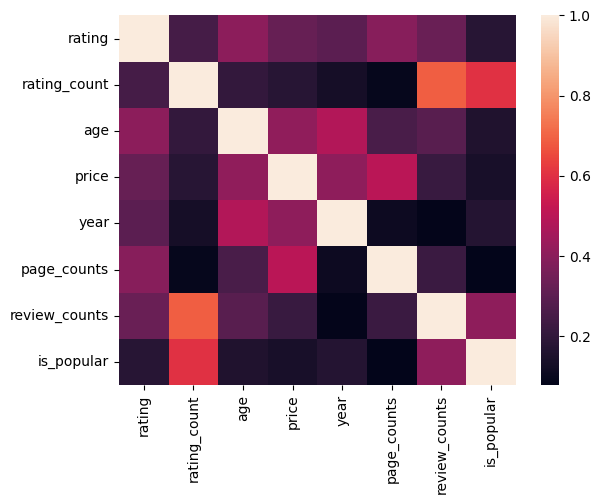

In [160]:
sns.heatmap(df.select_dtypes(include='number').corr())

Самые большие корреляции - у rating_count с review_count и ispopular. Второе не удивительно, так как is_popular буквально так создавалась. Первое тоже логично - и rating_count, и review count - это некоторая метрика популярности и количества людей которые ее прочитали.

Прикольно, что у цены есть неплохая корреляция с количеством страниц в книге. Опять же наверное логично, но смешно.

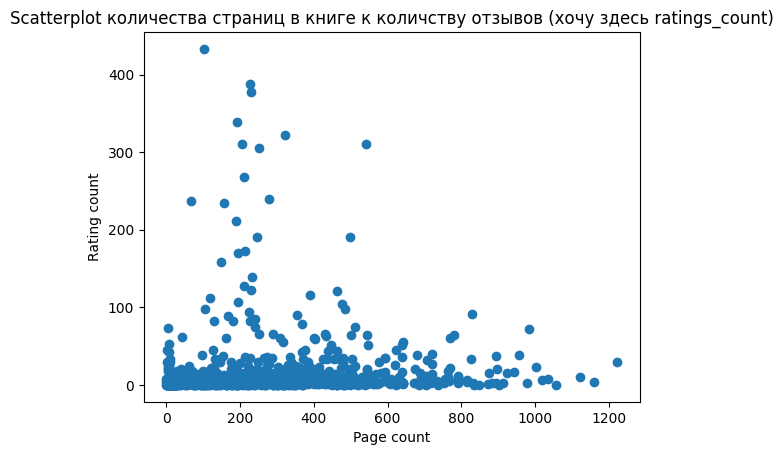

In [165]:
from matplotlib import pyplot as plt

plt.scatter(df['page_counts'], df['rating_count'])
plt.xlabel('Page count')
plt.ylabel('Rating count')
plt.title('Scatterplot количества страниц в книге к количству отзывов (хочу здесь ratings_count)')
plt.show()

Кажется, что нормальным состоянием является от 0 до 50 отзывов, от 50 до 100 - случается и это очень хорошо, а остальное - это выбросы очень популярных книг. Причем,что такое большое количество популярных книг именно с $\approx$ 200 страницами. Кажется людям нравятся bite-sized контент по программированию, а не учебники Страуструпа. 

Text(0, 0.5, 'Book count')

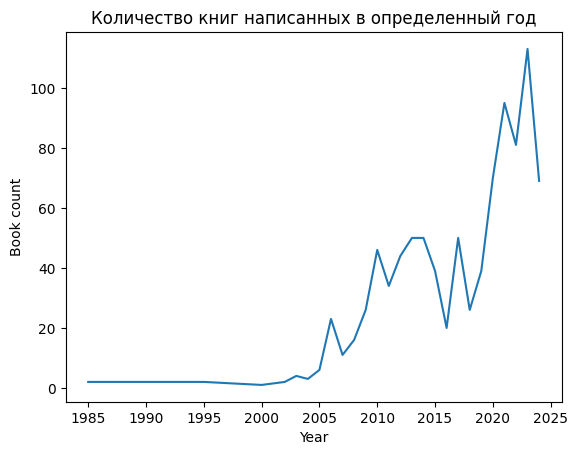

In [170]:
plt.plot(df.groupby(['year']).size())
plt.title('Количество книг написанных в определенный год')
plt.xlabel('Year')
plt.ylabel('Book count')

Вау, книги по программированию начали много писать где-то в 2005 году. И потом еще один бум в 2015-2020. А 2024 год еще не закончился, так что может быть еще их количество возрастет.

In [173]:
df.groupby(by=['author']).agg(avg_rating = ('rating', np.mean), book_count = ('rating', len), rating_count = ('rating_count', np.sum))

/var/folders/79/6xr_56fd17741_p8nnbtqk2cx4vq18/T/ipykernel_1370/4132446084.py:1: FutureWarning: The provided callable <function mean at 0x11846a0d0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(by=['author']).agg(avg_rating = ('rating', np.mean), book_count = ('rating', len), rating_count = ('rating_count', np.sum))
/var/folders/79/6xr_56fd17741_p8nnbtqk2cx4vq18/T/ipykernel_1370/4132446084.py:1: FutureWarning: The provided callable <function sum at 0x11846d160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.groupby(by=['author']).agg(avg_rating = ('rating', np.mean), book_count = ('rating', len), rating_count = ('rating_count', np.sum))


,avg_rating,book_count,rating_count
author,,,
Arsen Gonian,5.00,1,5
C. И. Никишов,4.67,1,9
ChatGPT-4,3.89,2,43
Chris Totten,0.00,1,0
Eugeny Shtoltc,2.50,2,2
...,...,...,...
Якоб Нильсен,3.79,1,33
Ян Гойвертс,4.00,2,4
Ян Пойнтер,3.60,1,5


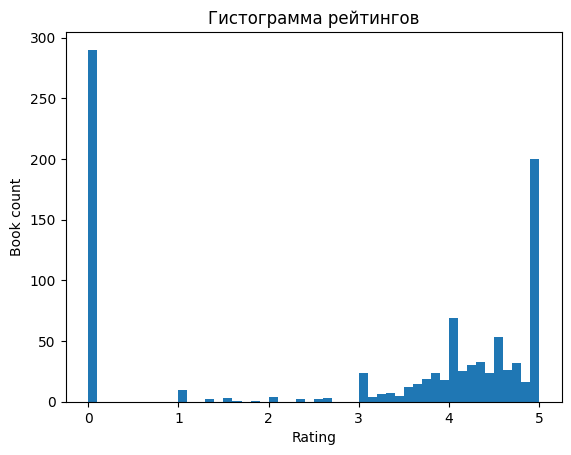

In [177]:
plt.hist(df['rating'], bins=50)
plt.title('Гистограмма рейтингов')
plt.xlabel('Rating')
plt.ylabel('Book count')
plt.show()

Интересно, что оценки настолько смещенны к буквально чистым пятеркам. А еще что в датасете треть книг вообще без отзывов))))  
В общем для рек систем кажется стоило бы ставить: если не 5, то не понравилось...

In [181]:
from collections import Counter

languages = ['python', 'c++', 'pascal', 'fortran', 'rust', 'go']

lang_counter = Counter()

for name in df['name']:
    name = name.lower()
    for lang in languages:
        if lang in name:
            lang_counter[lang] += 1

lang_counter


Counter({'python': 95, 'c++': 23, 'go': 15, 'pascal': 4, 'rust': 2})

А еще можно посчитать на какие языки приходятся эти учебники. Не очень удивительно, что Python очень лидирует, а фортрана нет. А Go - еще нужно было бы проверить, что это не часть какого-то слова.

А еще в датасете можно найти книги от ChatGPT, повторы имен книг (оказывается аудиокниги) и многое другое.

In [180]:
df.groupby(by=['name']).size().sort_values()

name
#Сам себе программист. Как научиться программировать и устроиться в Ebay                                             1
Понятный Python. С наглядным кодом, для детей и начинающих                                                           1
Последнее доказательство существования Творца                                                                        1
Постановка задач имитационного моделирования тактических защитных конкурентных действий                              1
Постановка задачи обеспечения автоматизации полного цикла поддержки принятия решения                                 1
                                                                                                                    ..
Fallout. Хроники создания легендарной саги                                                                           2
Геймдизайн на практике. Как начать зарабатывать                                                                      2
Краткое изложение книги «Геймдизайн. Как со

In [185]:
df[df['author'] == 'ChatGPT-4']

,name,link,rating,rating_count,age,price,author,year,text_reviews,page_counts,review_counts,is_popular
473,Автобиография нейросети,https://www.litres.ru/audiobook/chat-gpt-4/avt...,3.95,20,16,399.0,ChatGPT-4,2023.0,"[Удивлена сильно, что меня так зацепила данная...",4.0,6,0
474,Автобиография нейросети,https://www.litres.ru/book/chat-gpt-4/avtobiog...,3.83,23,16,319.0,ChatGPT-4,2023.0,[Годится для ссылок в статьях. Рисовать авторы...,130.0,12,0


Ну и посчитаем количество аудиокниг и обычных книг ибо фантазии нет.

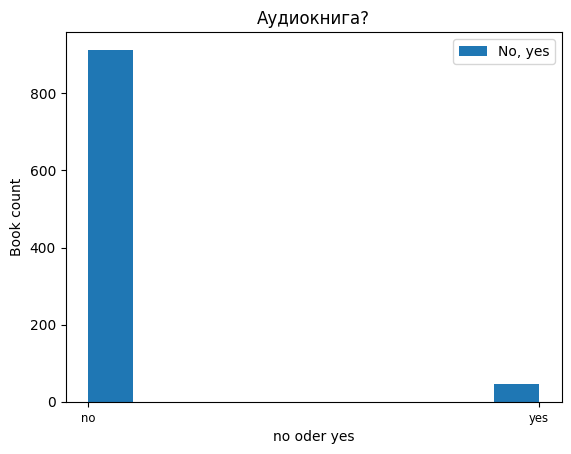

In [194]:
df['is_audiobook'] = df['link'].apply(lambda link: int('audiobook' in link))
plt.hist(df['is_audiobook'])
plt.legend(['No, yes'])
plt.title('Аудиокнига?')
plt.xticks(range(2), ['no', 'yes'], size='small')
plt.ylabel('Book count')
plt.xlabel('no oder yes')
plt.show()

Я не сдержался